In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('2018-02-01/2018-02-01_BINS_XETR08.csv')

We'll do some EDA on the first hour of the first day of the data set.

In [4]:
data.columns

Index(['ISIN', 'Mnemonic', 'SecurityDesc', 'SecurityType', 'Currency',
       'SecurityID', 'Date', 'Time', 'StartPrice', 'MaxPrice', 'MinPrice',
       'EndPrice', 'TradedVolume', 'NumberOfTrades'],
      dtype='object')

In [3]:
print(len(data.dropna()))
print(len(data))

8856
8856


No missing values! It appears that there are no missing values.  Good, this saves us a bit of a headache.

In [6]:
len(data.ISIN.unique())

824

In [7]:
len(data.Mnemonic.unique())

824

In [42]:
len(data.SecurityDesc.unique())

819

In [45]:
len(data.SecurityID.unique())

824

Given how close the number of unique values are for each of these features, I suspect we can delete some.  Let's check.

In [4]:
from collections import defaultdict as dd
d = dd(lambda:[])
e = dd(lambda:[])
count = 0
failure = 0
for i,j in zip(data['ISIN'],data['Mnemonic']):
    if i not in d[j]:
        d[j].append(i)
    if len(d[j])>1:
        print('failure')
        failure = 1
        break
if failure==0:
    for i,j in zip(data['ISIN'],data['Mnemonic']):
        if j not in e[i]:
            e[i].append(j)
        if len(e[i])>1:
            print('failure')
            failure = 1
            break
if failure==0:
    print('all good! delete one of them!')

all good! delete one of them!


In [5]:
del data['ISIN']

In [6]:
e = dd(lambda:[])
f = dd(lambda:[])
count = 0
failure = 0
for i,j in zip(data['SecurityID'],data['Mnemonic']):
    if i not in e[j]:
        e[j].append(i)
    if len(e[j])>1:
        print('failure')
        failure = 1
        break
if failure==0:
    for i,j in zip(data['SecurityID'],data['Mnemonic']):
        if j not in f[i]:
            f[i].append(j)
        if len(f[i])>1:
            print('failure')
            failure = 1
            break
if failure==0:
    print('all good! delete one of them!')

all good! delete one of them!


In [7]:
del data['SecurityID']

Security descriptions are not quite one to one and onto. Let's investigate

In [8]:
f = dd(lambda:[])
g = dd(lambda:[])
count = 0
failure = 0
for i,j in zip(data['SecurityDesc'],data['Mnemonic']):
    if i not in f[j]:
        f[j].append(i)
    if len(f[j])>1:
        print('failure')
        failure = 1
        break
if failure==0:
    for i,j in zip(data['SecurityDesc'],data['Mnemonic']):
        if j not in g[i]:
            g[i].append(j)
        if len(g[i])>1:
            print(i, end = ': ')
            for k in g[i]:
                print(k, end = ', ')
            print(' ')

COMMERZBANK ETC UNL.: X0D2, X0C1,  
COMMERZBANK ETC UNL.: X0D2, X0C1, X005,  
COMMERZBANK ETC UNL.: X0D2, X0C1, X005, X0C5,  
COMMERZBANK ETC UNL.: X0D2, X0C1, X005, X0C5, X001,  
ETFS COM.SEC.DZ08/UN.IDX: 4RUD, 4RUH,  
COMMERZBANK ETC UNL.: X0D2, X0C1, X005, X0C5, X001,  
COMMERZBANK ETC UNL.: X0D2, X0C1, X005, X0C5, X001,  
COMMERZBANK ETC UNL.: X0D2, X0C1, X005, X0C5, X001,  
ETFS COM.SEC.DZ08/UN.IDX: 4RUD, 4RUH,  
ETFS COM.SEC.DZ08/UN.IDX: 4RUD, 4RUH,  
COMMERZBANK ETC UNL.: X0D2, X0C1, X005, X0C5, X001,  


Security Description doesn't seem to be differentiating anything all that much.  Let's go ahead and delete that too.

In [9]:
del data['SecurityDesc']

15

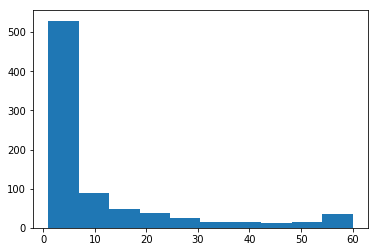

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(data.groupby('Mnemonic').count()['NumberOfTrades'])
len(data.groupby('Mnemonic').count()['NumberOfTrades'][data.groupby('Mnemonic').count().NumberOfTrades > 59])

It looks like only 15 securities were traded every minute of this hour.  If our goal is to build a high frequency trading engine, we'll want to focus on securities that are traded frequently.  Before we go and subset the data, though, let's look at the activity of the other hours and other days in this month.

In [10]:
mens = []
for i in data.Mnemonic.unique():
    if len(data[data.Mnemonic==i])>59:
        mens.append(i)

In [11]:
subed = data[[x in mens for x in data.Mnemonic]]

In [12]:
subed.SecurityType.unique()

array(['Common stock'], dtype=object)

Among frequently traded securities, the security type appears to be unique, so keeping this data field is unnecessary.

In [13]:
del subed['SecurityType']

In [14]:
subed.Currency.unique()

array(['EUR'], dtype=object)

Same logic with the Currency.

In [97]:
del subed['Currency']

In [99]:
len(subed)

900

In [38]:
lht = pd.read_csv('2018-02-01/2018-02-01_BINS_XETR16.csv')
lht.Time.unique()

array(['16:00', '16:01', '16:02', '16:03', '16:04', '16:05', '16:06',
       '16:07', '16:08', '16:09', '16:10', '16:11', '16:12', '16:13',
       '16:14', '16:15', '16:16', '16:17', '16:18', '16:19', '16:20',
       '16:21', '16:22', '16:23', '16:24', '16:25', '16:26', '16:27',
       '16:28', '16:29', '16:30'], dtype=object)

Looks like the trading day ends at 4:30, so hour 16 only has 31 minutes.

Ok, now let's try it with all of the data.

In [2]:
import pandas as pd
import numpy as np
days = ['01','02','05','06','07','08','09','12','13','14','15','16','19','20','21','22','23','26','27','28']
hours = ['08','09','10','11','12','13','14','15','16']
dfs = []
for i in days:
    for j in hours:
        fpath = '2018-02-' + i + '/2018-02-' + i + '_BINS_XETR' + j + '.csv'
        try:
            dfs.append(pd.read_csv(fpath))
        except:
            print('day ' + i + ' hour ' + j + ' is missing')
            continue
data = pd.concat(dfs)

day 06 hour 15 is missing
day 09 hour 15 is missing


It looks like no trading happened from 3-4 pm on February 6th and 9th, 2018.  We'll have to keep this in mind for later.

Let's see if we can delete ISIN and Security ID fields 

In [3]:
from collections import defaultdict as dd
delfields = ['ISIN', 'SecurityID']
for k in delfields:
    d = dd(lambda:[])
    e = dd(lambda:[])
    count = 0
    failure = 0
    for i,j in zip(data[k],data['Mnemonic']):
        if i not in d[j]:
            d[j].append(i)
        if len(d[j])>1:
            failure = 1
    if failure==0 or failure==1:
        for i,j in zip(data[k],data['Mnemonic']):
            if j not in e[i]:
                e[i].append(j)
            if len(e[i])>1:
                failure = 1
    if failure==0:
        print('all good! deleting ' + k + '!')
        del data[k]
    for k,v in d.items():
        if len(v)>1:
            print(k)
            print(v)
            print(' ')
    print(' ')
    alb = True
    for k,v in e.items():
        if len(v)>1:
            alb = False
            print(k)
            print(v)
            print(' ')
    print(alb)

GC40
['FR0007080973', 'LU1681046931']
 
18MM
['FR0010713669', 'LU1602144906']
 
V50A
['FR0010654913', 'LU1681047236']
 
LWCR
['FR0012657963', 'LU1602144229']
 
SM8T
['FR0011829084', 'LU1602145119']
 
AMED
['FR0010655688', 'LU1602144575']
 
J1GR
['FR0010688242', 'LU1602144732']
 
 
True
GC40
[2505191, 2993648]
 
18MM
[2505268, 2993646]
 
V50A
[2506388, 2993649]
 
LWCR
[2505340, 2993643]
 
SM8T
[2505332, 2993647]
 
AMED
[2505251, 2993644]
 
J1GR
[2505266, 2993645]
 
 
True


It looks like a select few Mnemonics have two ISINs. Interesting.  We'll hold off on deleting the ISIN field for now and will come back to this later.

In the next cell, we'll figure out how many hours each Mnemonic was traded every minute.

In [4]:
import pandas as pd
import numpy as np
from collections import defaultdict as dd
days = ['01','02','05','06','07','08','09','12','13','14','15','16','19','20','21','22','23','26','27','28']
hours = ['08','09','10','11','12','13','14','15','16']
dfs = []
initial = pd.read_csv('2018-02-01/2018-02-01_BINS_XETR08.csv')
mend = dd(int)
for i in days:
    for j in hours:
        fpath = '2018-02-' + i + '/2018-02-' + i + '_BINS_XETR' + j + '.csv'
        try:
            dat2 = pd.read_csv(fpath)
            mens = []
            for k in dat2.Mnemonic.unique():
                if len(dat2[dat2.Mnemonic==k])>len(dat2.Time.unique())-1:
                    mens.append(k)
            for k in mens:
                mend[k]+=1
        except:
            print('day ' + i + ' hour ' + j + ' is missing')
            continue
for k,v in mend.items():
    print(k+': '+str(v))

day 06 hour 15 is missing
day 09 hour 15 is missing
VNA: 24
BAS: 137
BAYN: 122
CBK: 76
BMW: 109
DPW: 52
DTE: 88
FME: 19
IFX: 60
RWE: 69
SAP: 128
VOW3: 119
LHA: 21
ALV: 114
MUV2: 55
ADS: 46
EOAN: 115
SHA: 11
WAF: 8
DBK: 102
CON: 31
DAI: 120
SIE: 114
FRE: 45
PSM: 11
MRK: 16
TKA: 22
SNH: 11
DWNI: 6
LEG: 4
PAH3: 13
WCH: 11
FRA: 5
1COV: 38
NDA: 16
B4B: 3
AT1: 1
HEI: 21
LINU: 14
BEI: 12
WDI: 21
IGY: 14
LXS: 7
G1A: 7
SY1: 4
UTDI: 1
EVT: 2
DB1: 3
EXX1: 2
HEN3: 10
EVK: 7
EXS1: 2
BOSS: 5
KGX: 6
LEO: 3
OSR: 7
ZAL: 3
AIR: 1
ADE: 1
UN01: 1
TUI1: 2
ARL: 1
FPE3: 1
RHM: 1
DMP: 1
NEM: 1
QIA: 1
BNR: 2
SZG: 7
EXSA: 9
O2D: 2
VOW: 1
AIXA: 3
EXV1: 7
VJPN: 1


In [5]:
for k,v in mend.items():
    if v>100:
        print(k)

BAS
BAYN
BMW
SAP
VOW3
ALV
EOAN
DBK
DAI
SIE


It appears that the above 10 securities are the most frequently traded securities.  Since we're trying to build a high frequency trading engine, we'll focus on these.

In [6]:
fmends = []
for k,v in mend.items():
    if v>100:
        fmends.append(k)
print(fmends)

['BAS', 'BAYN', 'BMW', 'SAP', 'VOW3', 'ALV', 'EOAN', 'DBK', 'DAI', 'SIE']


In [7]:
data2 = data[[x in fmends for x in data.Mnemonic]]

In [8]:
from collections import defaultdict as dd
d = dd(lambda:[])
e = dd(lambda:[])
count = 0
failure = 0
for i,j in zip(data2['ISIN'],data2['Mnemonic']):
    if i not in d[j]:
        d[j].append(i)
    if len(d[j])>1:
        print('failure')
        failure = 1
        break
if failure==0:
    for i,j in zip(data2['ISIN'],data2['Mnemonic']):
        if j not in e[i]:
            e[i].append(j)
        if len(e[i])>1:
            print('failure')
            failure = 1
            break
if failure==0:
    print('all good! deleting ISIN!')
    del data2['ISIN']

all good! deleting ISIN!


In [9]:
e = dd(lambda:[])
f = dd(lambda:[])
count = 0
failure = 0
for i,j in zip(data2['SecurityID'],data2['Mnemonic']):
    if i not in e[j]:
        e[j].append(i)
    if len(e[j])>1:
        print('failure')
        failure = 1
        break
if failure==0:
    for i,j in zip(data2['SecurityID'],data2['Mnemonic']):
        if j not in f[i]:
            f[i].append(j)
        if len(f[i])>1:
            print('failure')
            failure = 1
            break
if failure==0:
    print('all good! deleting SecurityID!')
    del data2['SecurityID']

all good! deleting SecurityID!


In [10]:
e = dd(lambda:[])
f = dd(lambda:[])
count = 0
failure = 0
for i,j in zip(data2['SecurityDesc'],data2['Mnemonic']):
    if i not in e[j]:
        e[j].append(i)
    if len(e[j])>1:
        print('failure')
        failure = 1
        break
if failure==0:
    for i,j in zip(data2['SecurityDesc'],data2['Mnemonic']):
        if j not in f[i]:
            f[i].append(j)
        if len(f[i])>1:
            print('failure')
            failure = 1
            break
if failure==0:
    print('all good! deleting Security Description!')
    del data2['SecurityDesc']

all good! deleting Security Description!


In [11]:
if(len(data2.SecurityType.unique()) ==1):
    print('Deleting Security Type')
    print('All securities are of type '+ data2.SecurityType.unique()[0])
    del data2['SecurityType']

Deleting Security Type
All securities are of type Common stock


In [69]:
del data2['SecurityType']

In [70]:
data2.columns

Index(['Mnemonic', 'Currency', 'Date', 'Time', 'StartPrice', 'MaxPrice',
       'MinPrice', 'EndPrice', 'TradedVolume', 'NumberOfTrades'],
      dtype='object')

In [12]:
if(len(data2.Currency.unique()) ==1):
    print('Deleting Currency')
    print('All currencies are of type '+ data2.Currency.unique()[0])
    del data2['Currency']

Deleting Currency
All currencies are of type EUR


In [75]:
print(fmends)
print(data2.Mnemonic.unique())

['BAS', 'BAYN', 'BMW', 'SAP', 'VOW3', 'ALV', 'EOAN', 'DBK', 'DAI', 'SIE']
['BAS' 'BAYN' 'EOAN' 'BMW' 'SAP' 'VOW3' 'ALV' 'DBK' 'DAI' 'SIE']


In [85]:
data2.head(30)

,index,Mnemonic,Date,Time,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades
0,6,BAS,2018-02-01,08:00,94.770,94.830,94.750,94.750,7676,49
1,7,BAYN,2018-02-01,08:00,105.920,105.960,105.840,105.860,6706,32
2,9,EOAN,2018-02-01,08:00,8.517,8.517,8.500,8.505,11232,13
3,15,BMW,2018-02-01,08:00,92.360,92.360,91.930,91.930,14755,80
4,40,SAP,2018-02-01,08:00,91.510,91.550,91.430,91.550,7297,64
5,43,VOW3,2018-02-01,08:00,178.600,179.000,178.040,178.360,6175,54
6,45,ALV,2018-02-01,08:00,204.550,204.850,204.550,204.650,5248,43
7,53,BAS,2018-02-01,08:01,94.700,94.700,94.590,94.590,1935,17
8,54,BAYN,2018-02-01,08:01,105.820,105.820,105.680,105.740,1424,16
9,56,EOAN,2018-02-01,08:01,8.510,8.535,8.510,8.535,45765,24


In [18]:
len(data2)

100008

Let's combine date and time to make a datetime; it'll be handy later.

In [13]:
dts = pd.to_datetime([x+y for x,y in zip(data2['Date'], data2['Time'])], format = '%Y-%m-%d%H:%M')

In [14]:
dts[:10]

DatetimeIndex(['2018-02-01 08:00:00', '2018-02-01 08:00:00',
               '2018-02-01 08:00:00', '2018-02-01 08:00:00',
               '2018-02-01 08:00:00', '2018-02-01 08:00:00',
               '2018-02-01 08:00:00', '2018-02-01 08:01:00',
               '2018-02-01 08:01:00', '2018-02-01 08:01:00'],
              dtype='datetime64[ns]', freq=None)

In [15]:
data2['DateTime'] = dts

/Users/subramanianiyer/anaconda2/envs/mypython3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
data2.head()

,Mnemonic,Date,Time,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades,DateTime
6,BAS,2018-02-01,08:00,94.770,94.830,94.75,94.750,7676,49,2018-02-01 08:00:00
7,BAYN,2018-02-01,08:00,105.920,105.960,105.84,105.860,6706,32,2018-02-01 08:00:00
9,EOAN,2018-02-01,08:00,8.517,8.517,8.50,8.505,11232,13,2018-02-01 08:00:00
15,BMW,2018-02-01,08:00,92.360,92.360,91.93,91.930,14755,80,2018-02-01 08:00:00
40,SAP,2018-02-01,08:00,91.510,91.550,91.43,91.550,7297,64,2018-02-01 08:00:00


In [17]:
del data2['Date']
del data2['Time']

We'll pickle this for later.

In [19]:
import pickle
with open('check1.pkl', 'wb') as picklefile:
    pickle.dump(data2, picklefile)

Let's make sure we chose the right companies.  We chose the companies that had over 100 hours of trading every minute, but let's make sure that also corresponds to the companies traded over the most minutes.

day 06 hour 15 is missing
day 09 hour 15 is missing


(array([ 1839.,   110.,    49.,    32.,    34.,    10.,    18.,    16.,
            9.,    27.]),
 array([  1.00000000e+00,   1.00390000e+03,   2.00680000e+03,
          3.00970000e+03,   4.01260000e+03,   5.01550000e+03,
          6.01840000e+03,   7.02130000e+03,   8.02420000e+03,
          9.02710000e+03,   1.00300000e+04]),
 <a list of 10 Patch objects>)

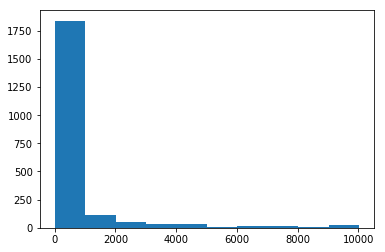

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict as dd
days = ['01','02','05','06','07','08','09','12','13','14','15','16','19','20','21','22','23','26','27','28']
mend2 = dd(int)
for i in days:
    for j in hours:
        fpath = '2018-02-' + i + '/2018-02-' + i + '_BINS_XETR' + j + '.csv'
        try:
            dat2 = pd.read_csv(fpath)
            for k in dat2.Mnemonic:
                mend2[k]+=1
        except:
            print('day ' + i + ' hour ' + j + ' is missing')
            continue
totalT = []
for k,v in mend2.items():
    totalT.append(v)
plt.hist(totalT)

In [21]:
for k,v in mend2.items():
    if v>9900:
        print(k)
        print(v)

BAS
10030
BAYN
10011
EOAN
9999
BMW
9981
SAP
10021
VOW3
10000
ALV
9983
DBK
9984
DAI
10009
SIE
9990


It's the same 10 companies, so we're ok. In the next notebook, we'll start off with what we pickled and impute some missing values.